Downloading MNIST

In [1]:
from pathlib import Path
import requests

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

In [3]:
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

In [4]:
if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

Unpacking MNIST

In [5]:
import pickle
import gzip

In [6]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Look at the data

In [7]:
import matplotlib.pyplot as plt
import numpy as np

(50000, 784)


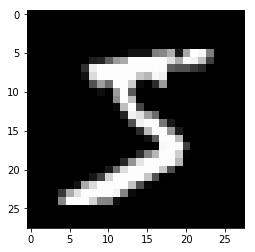

In [8]:
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

Writing a neural network

In [9]:
import torch

In [10]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [11]:
n, c = x_train.shape

In [12]:
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [13]:
import math

In [14]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [15]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

In [31]:
def model(xb):
    return log_softmax(xb @ weights + bias)

In [17]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.4496, -2.6459, -1.8688, -2.8691, -2.0725, -2.4566, -1.8705, -2.1447,
        -2.5908, -2.6039], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [18]:
def nll(values, target):
    return -values[range(target.shape[0]), target].mean()

In [19]:
loss_func = nll

In [20]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4554, grad_fn=<NegBackward>)


In [21]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [22]:
print(accuracy(preds, yb))

tensor(0.0312)


In [23]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [32]:
model(xb)

tensor([[-1.2152e+01, -1.5439e+01, -1.1437e+01, -1.2638e+01, -5.1993e+00,
         -1.2758e+01, -1.2055e+01, -6.9048e+00, -5.1106e+00, -1.2665e-02],
        [-4.6967e+00, -9.6513e+00, -1.5380e+00, -3.0405e-01, -1.4273e+01,
         -5.2679e+00, -3.7280e+00, -1.0583e+01, -4.7172e+00, -1.0608e+01],
        [-1.7164e+01, -1.3740e+01, -1.1596e+01, -9.1246e+00, -1.3900e+01,
         -1.3552e+01, -1.9443e+01, -4.6635e-03, -1.0970e+01, -5.4006e+00],
        [-3.7518e-01, -1.1310e+01, -3.3138e+00, -2.0727e+00, -8.8042e+00,
         -3.5941e+00, -2.3106e+00, -6.4885e+00, -4.5176e+00, -4.4808e+00],
        [-9.0681e+00, -1.8361e+01, -8.5631e+00, -6.3278e+00, -3.5251e+00,
         -5.8932e+00, -9.6255e+00, -4.1900e+00, -4.5605e+00, -6.1842e-02],
        [-1.3060e-02, -2.3392e+01, -7.5551e+00, -9.8841e+00, -1.6376e+01,
         -6.7933e+00, -4.4869e+00, -1.5317e+01, -1.0653e+01, -1.9209e+01],
        [-1.4285e+01, -1.8313e+01, -8.6506e+00, -4.8764e+00, -1.0802e+01,
         -6.4960e+00, -1.3831e+0

In [24]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0812, grad_fn=<NegBackward>) tensor(1.)


Adding torch.nn

In [25]:
import torch.nn.functional as F

In [26]:
loss_func = F.cross_entropy

In [27]:
def model(xb):
    return xb @ weights + bias

In [29]:
model(xb)

tensor([[ -2.6992,  -5.9866,  -1.9847,  -3.1853,   4.2535,  -3.3053,  -2.6021,
           2.5480,   4.3422,   9.4401],
        [  2.0742,  -2.8804,   5.2329,   6.4669,  -7.5020,   1.5030,   3.0429,
          -3.8120,   2.0537,  -3.8366],
        [ -5.6949,  -2.2713,  -0.1273,   2.3445,  -2.4308,  -2.0827,  -7.9737,
          11.4644,   0.4991,   6.0684],
        [  4.4878,  -6.4473,   1.5491,   2.7903,  -3.9413,   1.2689,   2.5523,
          -1.6255,   0.3453,   0.3821],
        [ -2.0415, -11.3346,  -1.5365,   0.6988,   3.5015,   1.1333,  -2.5989,
           2.8366,   2.4660,   6.9647],
        [ 11.6679, -11.7114,   4.1259,   1.7968,  -4.6949,   4.8877,   7.1940,
          -3.6356,   1.0280,  -7.5278],
        [ -3.9957,  -8.0235,   1.6388,   5.4129,  -0.5122,   3.7933,  -3.5417,
          -3.8162,  10.2799,   0.7239],
        [  0.6798,  -2.9987,  -1.5317,   7.5650,  -5.5483,  11.3291,   4.0812,
          -5.4411,   3.9074,  -9.5062],
        [  0.7183, -10.1796,  -1.6507,   2.2523,

In [28]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward>) tensor(1.)


In [33]:
from torch import nn

In [40]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) /  math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [41]:
model = Mnist_Logistic()

In [42]:
print(loss_func(model(xb), yb))

tensor(2.2839, grad_fn=<NllLossBackward>)


In [45]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [46]:
fit()

In [47]:
print(loss_func(model(xb), yb))

tensor(0.0798, grad_fn=<NllLossBackward>)


In [48]:
print(accuracy(model(xb), yb))

tensor(1.)


In [49]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    
    def forward(self, xb):
        return self.lin(xb)

In [52]:
model = Mnist_Logistic()

In [53]:
print(loss_func(model(xb), yb))

tensor(2.3116, grad_fn=<NllLossBackward>)


In [54]:
fit()

In [55]:
print(loss_func(model(xb), yb))

tensor(0.0805, grad_fn=<NllLossBackward>)


Using optimizer

In [40]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) /  math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [56]:
from torch import optim

In [57]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [58]:
model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(2.4047, grad_fn=<NllLossBackward>)


In [59]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0821, grad_fn=<NllLossBackward>)


In [60]:
from torch.utils.data import TensorDataset

In [61]:
train_ds = TensorDataset(x_train, y_train)

In [62]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


In [63]:
from torch.utils.data import DataLoader

In [64]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [65]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0834, grad_fn=<NllLossBackward>)


Add validation

In [66]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

In [40]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) /  math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [68]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3066)
1 tensor(0.3586)


In [69]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt != None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [70]:
import numpy as np

In [73]:
list(zip((1, 2), (3, 4), (5, 6)))

[(1, 3, 5), (2, 4, 6)]

In [75]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)

In [77]:
def get_data(train_ds, valid_ds, bs):
    return(
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [79]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

In [80]:
model, opt = get_model()

In [81]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3363739710330963
1 0.28616599378585816


Switch to CNN

In [82]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

In [83]:
lr = 0.1

In [84]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [85]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34392044916152953
1 0.24528870515823364


In [86]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
    

In [100]:
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [101]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [102]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [103]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3096241057872772
1 0.3172306094169617


Wrapping data loader

In [104]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [105]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [110]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [111]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [112]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34537596306800844
1 0.26143329448699953
